In [1]:
#!pip install yfinance
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.15.0


In [2]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059441,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750252,132079200


In [3]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
# aapl_data.fillna(method='ffill', inplace=True)
aapl_data.ffill(inplace=True)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [5]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

In [6]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.layers import AdditiveAttention, Permute, Reshape, Multiply
import tensorflow as tf

model = Sequential()

# LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# The last LSTM layer should have return_sequences=True if followed by an attention layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and Reshape for compatibility - this is done to match the expected input shape of the attention layer
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))

# Applying the attention mechanism to the output of the LSTM layers
# We need to get the output of the model after the Reshape layer for the attention
attention_output = attention([model.output, model.output])
# Multiplying the LSTM outputs by the attention weights
multiply_layer = Multiply()([model.output, attention_output])

# We need to replace model.output with multiply_layer in the next layers
# However, we can't add layers like this using Sequential API after the model has been created,
# so we would need to use the Functional API instead.

# Flatten the output to feed into the Dense layer
model.add(Flatten())

# Final Dense layer for output
model.add(Dense(units=1))  # Assuming a regression problem

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

# Model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            

In [9]:
# # from keras.models import Sequential
# # from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

# # model = Sequential()

# # # Adding LSTM layers with return_sequences=True
# # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# # model.add(LSTM(units=50, return_sequences=True))
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

# model = Sequential()

# # Assuming X_train.shape[1] is the number of timesteps and X_train.shape[2] is the number of features

# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))

# # Second LSTM layer
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))

# # Third LSTM layer
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))

# # Fourth LSTM layer
# # Note that we set return_sequences=False for the last LSTM layer if it is followed by Dense layers
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(units=1))  # Assuming a regression problem; for classification, set the appropriate number of units and activation function

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')  # Use the appropriate loss function for your problem

# # Model summary
# model.summary()



# #ADD MORE LAYERS 

In [10]:
# # Adding self-attention mechanism
# # The attention mechanism
# attention = AdditiveAttention(name='attention_weight')
# # Permute and reshape for compatibility
# model.add(Permute((2, 1))) 
# model.add(Reshape((-1, X_train.shape[1])))
# attention_result = attention([model.output, model.output])
# multiply_layer = Multiply()([model.output, attention_result])
# # Return to original shape
# model.add(Permute((2, 1))) 
# model.add(Reshape((-1, 50)))

# # Adding a Flatten layer before the final Dense layer
# model.add(tf.keras.layers.Flatten())

# # Final Dense layer
# model.add(Dense(1))

# # Compile the model
# # model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# # history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

In [11]:
# from keras.layers import BatchNormalization

# # Adding Dropout and Batch Normalization
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [12]:
# model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# model.summary()

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100

25/25 [==============================] - 18s 259ms/step - loss: 0.0471 - val_loss: 0.0090
Epoch 2/100
25/25 [==============================] - 4s 139ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 3/100
25/25 [==============================] - 4s 148ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 4/100
25/25 [==============================] - 4s 149ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 5/100
25/25 [==============================] - 4s 143ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 6/100
25/25 [==============================] - 4s 143ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 7/100
25/25 [==============================] - 4s 145ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 8/100
25/25 [==============================] - 4s 149ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 9/100
25/25 [==============================] - 4s 146ms/step - loss: 0.0070 - val_loss: 0.0159
Epoch 10/100
25/25 [==============================] - 4s 140ms/step - loss: 0.0063 - val_

In [15]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 46ms/step - loss: 0.0016
Test Loss:  0.0015978676965460181


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 [==============================] - 3s 60ms/step
Mean Absolute Error:  0.029308561603064647
Root Mean Square Error:  0.039973336496872715


In [17]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 52ms/step
Predicted Stock Prices for the next 4 days:  [[171.811]]


In [18]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 72ms/step
Predicted Stock Prices for the next 4 days:  [171.811, 171.54358, 171.44026, 171.52834]


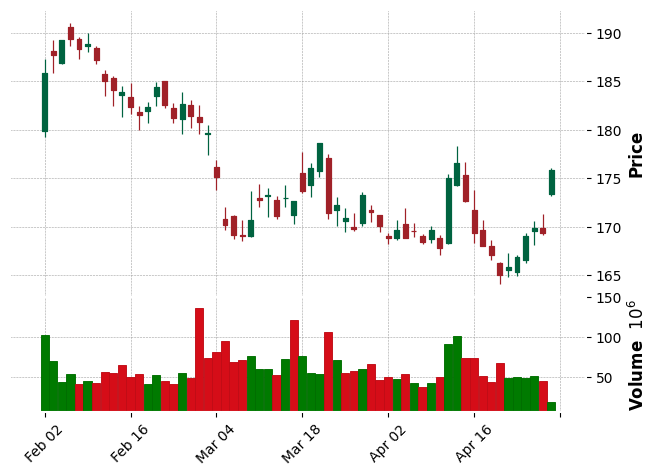

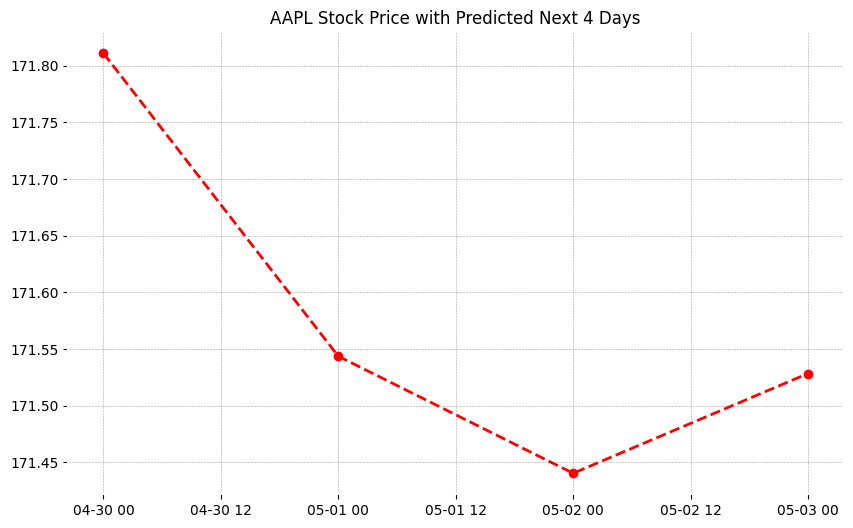

In [19]:
# !pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


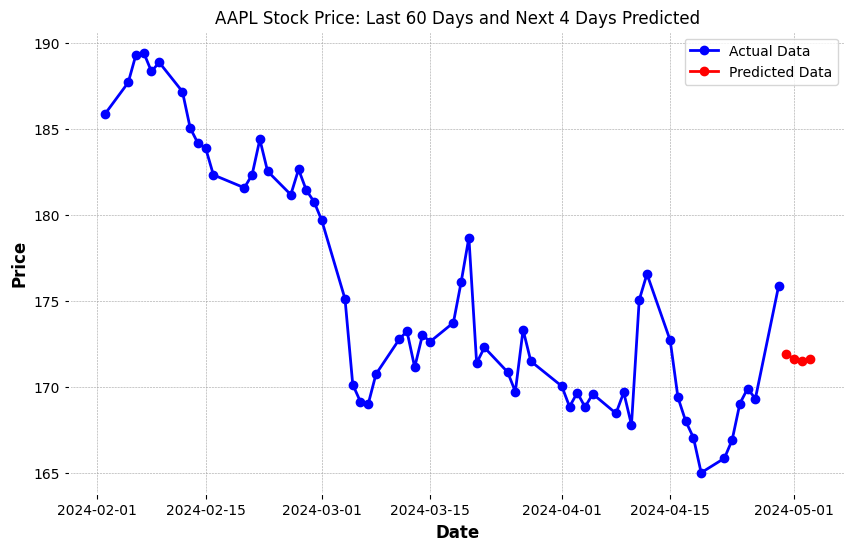

In [20]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()